### Load Pre-Trained Model and Data 

In [1]:
%matplotlib inline
import os
import torch
import random
import numpy as np
from experiments.apgs_bshape.models import init_models
from experiments.apgs_bshape.affine_transformer import Affine_Transformer
from experiments.apgs_bshape.main import train_apg
from experiments.apgs_bshape.gibbs import gibbs_sweeps
from combinators.utils import load_models
from experiments.apgs_bshape.dataset.loader import load_datapaths

device = torch.device('cuda:0')
use_markov_blanket = True

frame_pixels = 96
shape_pixels = 28
num_hidden_digit = 400
num_hidden_coor = 400
z_where_dim = 2
z_what_dim = 10

timesteps_test = 10
num_objects_test = 3
data_paths, mean_shape = load_datapaths("./dataset/", timesteps_test, num_objects_test)
mean_shape = mean_shape.to(device)
models = init_models(frame_pixels, 
                     shape_pixels, 
                     num_hidden_digit, 
                     num_hidden_coor, 
                     z_where_dim, 
                     z_what_dim, 
                     num_objects_test, 
                     mean_shape, 
                     device,
                     use_markov_blanket=use_markov_blanket)

load_models(models, 'running-model-1', map_location=lambda storage, loc: storage)

### Run APG algorithm

In [2]:
num_sweeps_test = 10
batch_size = 5
i = 0 # batch index 
frames = torch.load(random.choice(data_paths))[i:i+batch_size]
frames_expand = frames.unsqueeze(0).to(device)
apg = gibbs_sweeps(models, num_sweeps_test, timesteps_test)
out = apg(c={"frames": frames_expand}, sample_dims=0, batch_dim=1, reparameterized=False)

### Visualize Samples

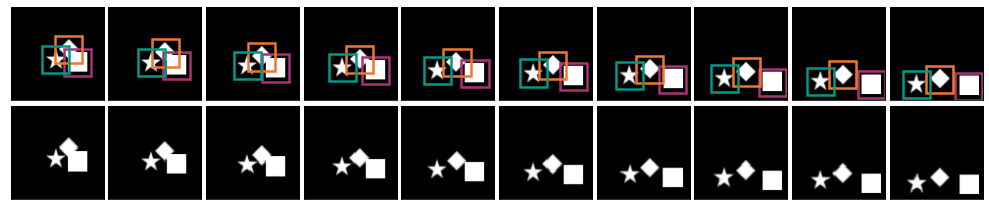

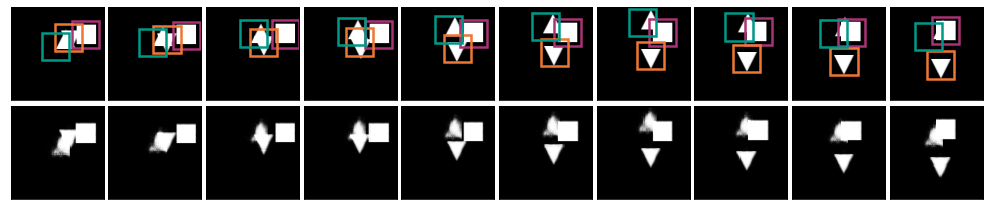

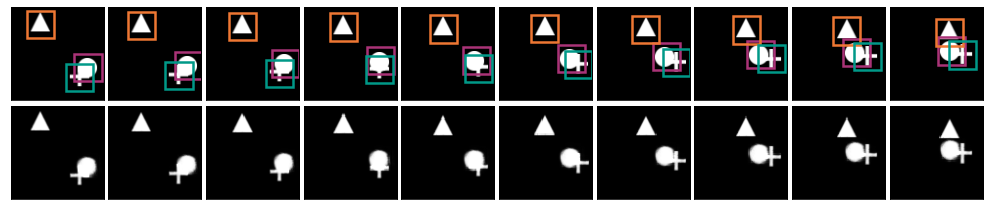

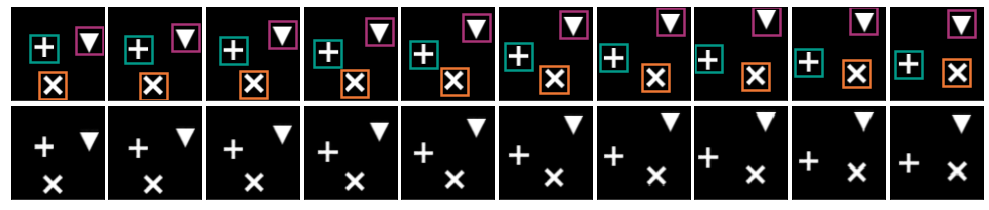

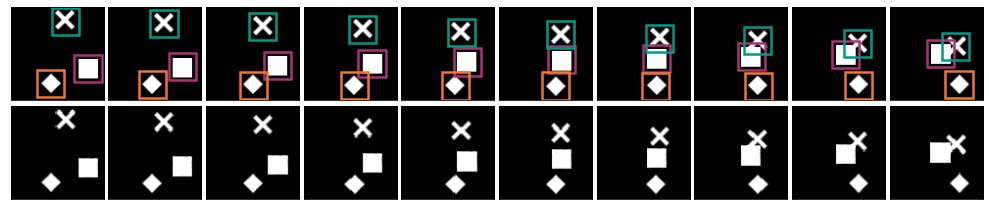

In [3]:
from experiments.apgs_bshape.evaluation import viz_samples, get_samples
rs, ws = get_samples(out, num_sweeps_test, timesteps_test)
viz_samples(frames, rs, ws, num_sweeps_test, num_objects_test, shape_pixels, fs=1.5, lw=2.5, save=True)